In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Dataset: Diagnostic Wisconsin Breast Cancer Dataset

__Source:__ https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [21]:
#load/clean/prep data
df = pd.read_csv('breast_cancer_data.csv')

#remove last column of Nans
df = df.drop('Unnamed: 32',1)

#change diagnosis to 0 (benign) or 1 (malignant)
df['diagnosis'] = df['diagnosis'].map(lambda x: 1 if x == 'M' else 0)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Feature Selection

In [3]:
#get variables with above .7 correlation to diagnosis
df_temp = pd.DataFrame(df.corr()['diagnosis'])
df_temp = df_temp.loc[df_temp['diagnosis'] >= .7].sort_values(['diagnosis'],
                                                             ascending=False)
df_temp = df_temp.reset_index()
variables = df_temp['index'].tolist()
#df_temp.head()

In [4]:
#dataframe with only selected variables
df2 = df[variables]
#df2.head()

In [5]:
#create train and test sets
trainsize = int(df2.shape[0] / 2)
df2_test = df2.iloc[trainsize:, :].copy()
df2_train = df2.iloc[:trainsize, :].copy()

#create data/target train and tests
Y_train = df2_train['diagnosis']
X_train = df2_train.loc[:, ~(df2_train.columns).isin(['diagnosis'])]
Y_test = df2_test['diagnosis']
X_test = df2_test.loc[:, ~(df2_test.columns).isin(['diagnosis'])]

## Vanilla Logistic Regression

In [6]:
#using statsmods
X_statsmod = df2.drop('diagnosis',1)
X_statsmod['intercept'] = 1

logit = sm.Logit(df2['diagnosis'], X_statsmod)
result = logit.fit()

#calculate accuracy
pred_statsmod = result.predict(X_statsmod)
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)
table = pd.crosstab(df2['diagnosis'], pred_y_statsmod)

print('\n Accuracy')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))

Optimization terminated successfully.
         Current function value: 0.099436
         Iterations 11

 Accuracy
col_0        0    1
diagnosis          
0          350    7
1           13  199

 Percentage accuracy
0.9648506151142355


In [7]:
#train lr model
lr = LogisticRegression(C=1) #C is parameter regularization coefficient
lr.fit(X_train, Y_train)
print('\nR-squared train:')
print(lr.score(X_train, Y_train))

#run on test set
print('\nR-squared test:')
print(lr.score(X_test, Y_test))

#double check with cross val score
from sklearn.model_selection import cross_val_score
scores_lr = cross_val_score(lr,
                            df2.drop('diagnosis', 1),
                            df2['diagnosis'],
                            cv=10)
print('\nscore array:\n', scores_lr)
print('\nscore array mean:\n', np.mean(scores_lr))
print('\nscore array std dev:\n', np.std(scores_lr))


R-squared train:
0.9471830985915493

R-squared test:
0.9298245614035088

score array:
 [0.94827586 0.9137931  0.94736842 0.94736842 0.98245614 0.94736842
 0.96491228 0.91071429 0.94642857 0.96428571]

score array mean:
 0.9472971221156339

score array std dev:
 0.02073068592217738


## Ridge Regression

In [8]:
#train ridge model
ridgeregr = linear_model.Ridge(alpha=.01, fit_intercept=False)
ridgeregr.fit(X_train, Y_train)
print('\nR-squared train:')
print(ridgeregr.score(X_train, Y_train))

#run model on test
print('\nR-squared test:')
print(ridgeregr.score(X_test, Y_test))

#double check with cross val score
scores_ridge = cross_val_score(ridgeregr,
                               df2.drop('diagnosis', 1),
                               df2['diagnosis'],
                               cv=10)
print('\nscore array:\n', scores_ridge)
print('\nscore array mean:\n', np.mean(scores_ridge))
print('\nscore array std dev:\n', np.std(scores_ridge))


R-squared train:
0.6867575100055208

R-squared test:
0.6454724979591079

score array:
 [0.2703434  0.66257333 0.72267369 0.53561563 0.76558856 0.73069538
 0.76484704 0.69557487 0.61677779 0.67534941]

score array mean:
 0.6440039098479693

score array std dev:
 0.14113419905618735


## Lasso Regression

In [9]:
#train lasso model
lass = linear_model.Lasso(alpha=.02)
lass.fit(X_train, Y_train)
print('\nR-squared train:')
print(lass.score(X_train, Y_train))

#run lasso on test
print('\nR-squared train:')
print(lass.score(X_test, Y_test))

#double check with cross val score
scores_lass = cross_val_score(lass,
                              df2.drop('diagnosis', 1),
                              df2['diagnosis'],
                              cv=10)
print('score array:\n', scores_lass)
print('\nscore array mean:\n', np.mean(scores_lass))
print('\nscore array std dev:\n', np.std(scores_lass))


R-squared train:
0.6506812508302292

R-squared train:
0.515935196268377
score array:
 [0.01551192 0.59547784 0.62865625 0.59932014 0.72584231 0.6473738
 0.64216165 0.6199679  0.49464074 0.60574388]

score array mean:
 0.5574696436663602

score array std dev:
 0.1886188071844782


### Results

Vanilla logistic regression far outperform Ridge and Lasso, which are less accurate and overfit more.

Mentor questions:
- this seems strange, is this right?
- ill conditioned matrix warning?

## Try some new stuff

### Pass regularization parameters into vanilla logistic regression

In [10]:
#Ridge L2
lrl2 = LogisticRegression(C=1, penalty='l2')
lrl2.fit(X_train, Y_train)
print('\nR-squared train:')
print(lrl2.score(X_train, Y_train))

#run on test set
print('\nR-squared test:')
print(lrl2.score(X_test, Y_test))

#double check with cross val score
scores_lrl2 = cross_val_score(lrl2,
                            df2.drop('diagnosis', 1),
                            df2['diagnosis'],
                            cv=10)
print('\nscore array:\n', scores_lrl2)
print('\nscore array mean:\n', np.mean(scores_lrl2))
print('\nscore array std dev:\n', np.std(scores_lrl2))


R-squared train:
0.9436619718309859

R-squared test:
0.9298245614035088

score array:
 [0.94827586 0.9137931  0.94736842 0.94736842 0.98245614 0.94736842
 0.96491228 0.91071429 0.94642857 0.96428571]

score array mean:
 0.9472971221156339

score array std dev:
 0.02073068592217738


In [11]:
#Lasso L1
lrl1 = LogisticRegression(C=1, penalty='l1')
lrl1.fit(X_train, Y_train)
print('\nR-squared train:')
print(lrl1.score(X_train, Y_train))

#run on test set
print('\nR-squared test:')
print(lrl1.score(X_test, Y_test))

#double check with cross val score
scores_lrl1 = cross_val_score(lrl1,
                            df2.drop('diagnosis', 1),
                            df2['diagnosis'],
                            cv=10)
print('\nscore array:\n', scores_lrl1)
print('\nscore array mean:\n', np.mean(scores_lrl1))
print('\nscore array std dev:\n', np.std(scores_lrl1))


R-squared train:
0.9471830985915493

R-squared test:
0.9333333333333333

score array:
 [0.96551724 0.89655172 0.94736842 0.94736842 0.98245614 0.92982456
 0.96491228 0.92857143 0.94642857 0.96428571]

score array mean:
 0.947328450436436

score array std dev:
 0.023235377144316123


### Result:

Passing regularization parameters into log regr perform much better than the Ridge and Lasso models on their own, but perform similarly to log regr without the parameters

### Ridge classifier

In [12]:
from sklearn.linear_model import RidgeClassifier
ridgeclass = RidgeClassifier(alpha=.01, fit_intercept=False)
ridgeclass.fit(X_train,Y_train)

print('\nR-squared train:')
print(ridgeclass.score(X_train,Y_train))

print('\nR-squared test:')
print(ridgeclass.score(X_test, Y_test))

scores_ridgeclass = cross_val_score(ridgeclass,
                               df2.drop('diagnosis', 1),
                               df2['diagnosis'],
                               cv=10)
print('\nscore array:\n', scores_ridgeclass)
print('\nscore array mean:\n', np.mean(scores_ridgeclass))
print('\nscore array std dev:\n', np.std(scores_ridgeclass))


R-squared train:
0.9330985915492958

R-squared test:
0.9649122807017544

score array:
 [0.9137931  0.9137931  0.94736842 0.98245614 0.92982456 0.94736842
 0.9122807  0.96428571 0.94642857 0.92857143]

score array mean:
 0.9386170166796302

score array std dev:
 0.022134184592955408


### Results

Ridge classifier performs much better than ridge regression, but not better than L1 logistic regression

## Further feature engineering: handle multicollinearity

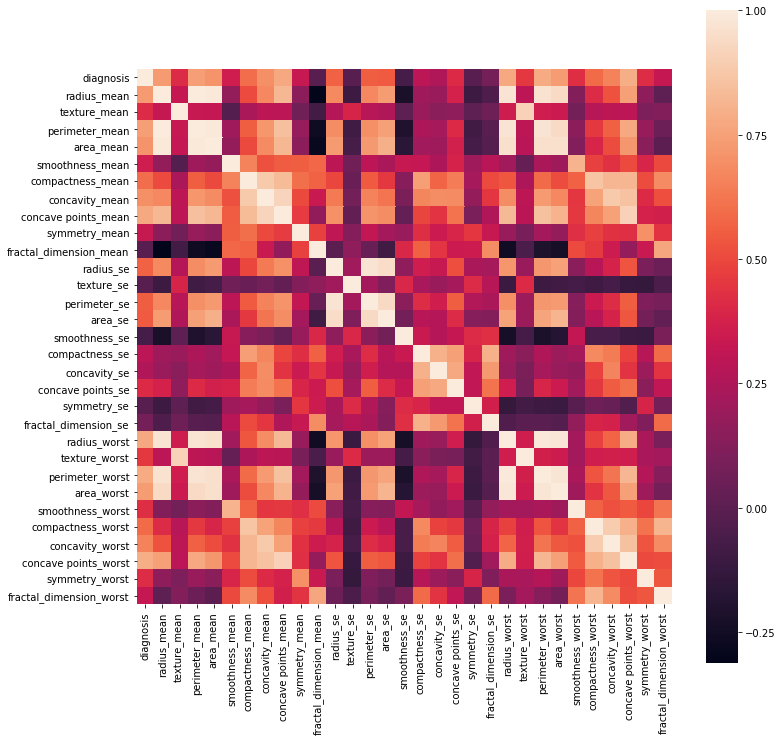

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


In [13]:
df = df.drop('id',1)
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), square=True)
plt.show()
df.corr()

In [14]:
c = df.corr()
s = c.unstack()
so = pd.DataFrame(s.sort_values(kind='quicksort'))
so = so.reset_index()
so.columns = ['var1', 'var2', 'corr']

#get rid of same variable sets
so = so[so['corr'] < 1]
so.drop_duplicates(subset='corr', keep='first', inplace=True)

#get rid of diagnosis correlations
so = so[(so.var1 != 'diagnosis') & (so.var2 != 'diagnosis')]

In [15]:
so_strong = so[so['corr'] >= .7]
so_moderate = so[(so['corr'] < .7) & (so['corr'] >= .5)]
so_weak = so[(so['corr'] < .5) & (so['corr'] >= .3)]

In [16]:
#drop strongly correlated variables
so_strong_vars = pd.unique(so_strong[['var2','var2']].values.ravel('K'))
df3 = df.drop(so_strong_vars, axis=1)
#df3.head()

In [17]:
#create train and test sets
trainsize = int(df3.shape[0] / 2)
df3_test = df3.iloc[trainsize:, :].copy()
df3_train = df3.iloc[:trainsize, :].copy()

#create data/target train and tests
Y_train3 = df3_train['diagnosis']
X_train3 = df3_train.loc[:, ~(df3_train.columns).isin(['diagnosis'])]
Y_test3 = df3_test['diagnosis']
X_test3 = df3_test.loc[:, ~(df3_test.columns).isin(['diagnosis'])]

In [18]:
#train vanilla
lr3 = linear_model.LogisticRegression(C=1)
lr3.fit(X_train3, Y_train3)
print('\nR-squared train:')
print(lr3.score(X_train3, Y_train3))

#test vanilla
print('\nR-squared test:')
print(lr3.score(X_test3, Y_test3))

scores_lr3 = cross_val_score(lr3,
                            df3.drop('diagnosis', 1),
                            df3['diagnosis'],
                            cv=10)
print('\nscore array:\n', scores_lr3)
print('\nscore array mean:\n', np.mean(scores_lr3))
print('\nscore array std dev:\n', np.std(scores_lr3))


R-squared train:
0.7922535211267606

R-squared test:
0.7157894736842105

score array:
 [0.81034483 0.84482759 0.80701754 0.71929825 0.89473684 0.80701754
 0.77192982 0.67857143 0.83928571 0.625     ]

score array mean:
 0.7798029556650247

score array std dev:
 0.07831018851733526


In [19]:
#train ridge
ridgeregr3 = linear_model.Ridge(alpha=.0001, fit_intercept=False)
ridgeregr3.fit(X_train3, Y_train3)
print('\nR-squared train:')
print(ridgeregr3.score(X_train3, Y_train3))

#test ridge
print('\nR-squared test:')
print(ridgeregr3.score(X_test3, Y_test3))

scores_ridge3 = cross_val_score(ridgeregr3,
                               df3.drop('diagnosis', 1),
                               df3['diagnosis'],
                               cv=10)
print('score array:\n', scores_ridge3)
print('\nscore array mean:\n', np.mean(scores_ridge3))
print('\nscore array std dev:\n', np.std(scores_ridge3))


R-squared train:
0.4313816646339532

R-squared test:
0.09169001623354067
score array:
 [-0.14620679  0.33551426  0.17836112  0.36514054  0.45721767  0.19266551
  0.34182805  0.20876296  0.20104855  0.18236568]

score array mean:
 0.23166975657154096

score array std dev:
 0.1557728916376869


In [20]:
#train lasso model
lass3 = linear_model.Lasso(alpha=.02)
lass3.fit(X_train3, Y_train3)
print('\nR-squared train:')
print(lass3.score(X_train3, Y_train3))

#run lasso on test
print('\nR-squared train:')
print(lass3.score(X_test3, Y_test3))

scores_lass3 = cross_val_score(lass3,
                              df3.drop('diagnosis', 1),
                              df3['diagnosis'],
                              cv=10)
print('score array:\n', scores_lass3)
print('\nscore array mean:\n', np.mean(scores_lass3))
print('\nscore array std dev:\n', np.std(scores_lass3))


R-squared train:
0.29331421844012096

R-squared train:
-0.1377844612420931
score array:
 [-0.79439114  0.25729218  0.28021882  0.33129953  0.18748776  0.27330566
  0.29239669 -0.01842135 -0.02084482 -0.25955246]

score array mean:
 0.05287908775583936

score array std dev:
 0.33482254092058716


### Results

All of this performs much worse, with much less accuracy and much more overfitting